In [15]:
import pandas as pd

from pandas_lib.std_imports import *
from Server_Cleaning.modules.Assignment_datasets import *
path = '../'

## age Analisys
We will 

In [16]:
p = get_players(path)[['player_id', 'name', 'date_of_birth']].dropna()
p.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30255 entries, 0 to 30301
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   player_id      30255 non-null  int64 
 1   name           30255 non-null  object
 2   date_of_birth  30255 non-null  object
dtypes: int64(1), object(2)
memory usage: 945.5+ KB


In [17]:
ge = get_game_events(path)[['date', 'type','player_id', 'description', 'player_assist_id']]
ge = ge.loc[ge['type'] != 'Shootout']
ge = ge.loc[ge['type'] != 'Substitutions']

ge['player_assist_id'].replace(float('NaN'), -1, inplace=True)
ge['player_assist_id'] = ge['player_assist_id'].astype('int')


def card_converter(x) :
    if 'red' in x or 'Red' in x :
        return 'red'
    elif 'yellow' in x or 'Yellow' in x :
        return 'yellow'
    else : 
        return 'goal'

ge['description']= ge['description'].apply(lambda x : card_converter(x))
ge.dropna(inplace=True)

ge = ge.loc[ge['player_id'].isin(p['player_id'])]
ge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 213349 entries, 0 to 666543
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   date              213349 non-null  object
 1   type              213349 non-null  object
 2   player_id         213349 non-null  int64 
 3   description       213349 non-null  object
 4   player_assist_id  213349 non-null  int32 
dtypes: int32(1), int64(1), object(3)
memory usage: 9.0+ MB


In [18]:
# added player_dob column
if 'date_of_birth' not in ge.columns :
    ge = ge.join(p[['player_id', 'date_of_birth']].set_index('player_id'), on='player_id')
ge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 213349 entries, 0 to 666543
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   date              213349 non-null  object
 1   type              213349 non-null  object
 2   player_id         213349 non-null  int64 
 3   description       213349 non-null  object
 4   player_assist_id  213349 non-null  int32 
 5   date_of_birth     213349 non-null  object
dtypes: int32(1), int64(1), object(4)
memory usage: 10.6+ MB


In [19]:
ge

,date,type,player_id,description,player_assist_id,date_of_birth
0,2012-08-05,Cards,4425,yellow,-1,1981-07-27
1,2012-08-05,Cards,33210,yellow,-1,1987-01-04
2,2012-08-05,Goals,36500,goal,56416,1986-07-03
3,2012-08-05,Goals,36500,goal,146258,1986-07-03
5,2012-08-05,Goals,38497,goal,33210,1987-11-24
...,...,...,...,...,...,...
666528,2023-11-14,Cards,67339,yellow,-1,1985-09-20
666534,2023-11-14,Cards,201570,yellow,-1,1995-05-03
666535,2023-11-14,Goals,201570,goal,918868,1995-05-03
666539,2023-11-15,Cards,129558,yellow,-1,1991-10-02


In [20]:
if 'assist_player_birth' not in ge.columns :
    ge = ge.join(p[['player_id', 'date_of_birth']].rename(columns={'player_id':'player_assist_id', 'date_of_birth':'assist_player_birth'}).set_index('player_assist_id'), on='player_assist_id')
    ge.replace(float('NaN'), None, inplace=True)
ge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 213349 entries, 0 to 666543
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 213349 non-null  object
 1   type                 213349 non-null  object
 2   player_id            213349 non-null  int64 
 3   description          213349 non-null  object
 4   player_assist_id     213349 non-null  int32 
 5   date_of_birth        213349 non-null  object
 6   assist_player_birth  26833 non-null   object
dtypes: int32(1), int64(1), object(5)
memory usage: 12.2+ MB


In [21]:
def fill_age(x) :
    date0 = x['date']
    if '-' in date0 : 
        year0 = int(date0[:date0.find('-')])
        
        date1 = x['date_of_birth']
        if '-' in date1 : 
            year1 = (int(date1[:date1.find('-')]))
            x['date_of_birth'] = year0 - year1
        
        if x['player_assist_id'] >= 0 and x['assist_player_birth'] is not None:
            if '-' in x['assist_player_birth']:
                year2 = int(x['assist_player_birth'][:x['assist_player_birth'].find('-')])
                x['assist_player_birth'] = year0 - year2
                x['description'] = 'assist'
        else :
            x['assist_player_birth'] = -1
            
                
    return x

if 'player_age' not in ge.columns:
    ge = ge.apply(lambda x : fill_age(x), axis=1).rename(columns={'assist_player_birth':'assist_player_age', 'date_of_birth':'player_age'})
    ge['date'] = pd.to_datetime(ge['date'].astype('string'))
ge.drop(columns=['player_id', 'player_assist_id'])

,date,type,description,player_age,assist_player_age
0,2012-08-05,Cards,yellow,31,-1
1,2012-08-05,Cards,yellow,25,-1
2,2012-08-05,Goals,assist,26,25
3,2012-08-05,Goals,assist,26,18
5,2012-08-05,Goals,assist,25,25
...,...,...,...,...,...
666528,2023-11-14,Cards,yellow,38,-1
666534,2023-11-14,Cards,yellow,28,-1
666535,2023-11-14,Goals,goal,28,-1
666539,2023-11-15,Cards,yellow,32,-1


<Axes: title={'center': "distribution of game events by players' age"}, xlabel='player_age'>

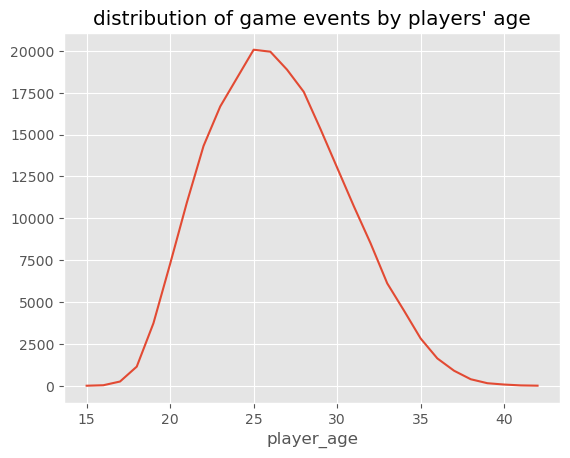

In [22]:
ge['player_age'].drop(columns=['player_id', 'player_assist_id']).value_counts().sort_index().plot(title='distribution of game events by players\' age')

In [23]:
ge['assist_player_age'].value_counts()

assist_player_age
-1     186516
 25      2741
 26      2646
 27      2399
 24      2332
 28      2082
 23      2080
 29      1907
 22      1839
 30      1570
 21      1551
 31      1287
 20       974
 32       944
 33       748
 19       507
 34       436
 35       269
 18       180
 36       164
 37        99
 38        28
 17        27
 40        10
 16         6
 39         6
 41         1
Name: count, dtype: int64

In [24]:
# sns.pairplot(penguins, kind="hist")

#violin plot
''' wanna get a subsets of players which has a carrier from at least their 22s and to 30s and visualize the distribution ofhow many goals and cards they achieve/get '''

# filtering events and players with ange in range
def filter_players_out_of_range(x) :
    if x['player_age'] < 22 or x['player_age'] > 30 :
        x['player_id'] = -1
    if x['assist_player_age'] < 22 or x['assist_player_age'] > 30 :
        x['player_assist_id'] = -1
        x['assist_player_age'] = -1
    return x

target_events = ge.query('(player_age >= 22 and player_age < 31) or (assist_player_age > 22 and assist_player_age < 31)').apply(lambda x: filter_players_out_of_range(x), axis=1).rename(columns={'player_assist_id':'assist_player_id'})
target_events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 158695 entries, 1 to 666543
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               158695 non-null  datetime64[ns]
 1   type               158695 non-null  object        
 2   player_id          158695 non-null  int64         
 3   description        158695 non-null  object        
 4   assist_player_id   158695 non-null  int64         
 5   player_age         158695 non-null  int64         
 6   assist_player_age  158695 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 9.7+ MB


In [25]:
target_events = target_events.loc[target_events['assist_player_id'].isin(target_events['player_id'])]
assist_df = target_events.query('description == "assist"')[['date', 'type','description', 'assist_player_id', 'assist_player_age']].rename(columns={'assist_player_id':'player_id', 'assist_player_age':'player_age'}).loc[target_events['assist_player_id']>=0]
goals_df = target_events.loc[target_events['player_age']>=0].drop(columns=['assist_player_id', 'assist_player_age']).loc[target_events['description']!='assist']
data_frames = pd.concat([goals_df, assist_df]).drop(columns=['player_id']).reset_index(drop=True).rename(columns={'player_id':'player_assist_id', 'player_age':'age'})

In [26]:
data_frames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153307 entries, 0 to 153306
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         153307 non-null  datetime64[ns]
 1   type         153307 non-null  object        
 2   description  153307 non-null  object        
 3   age          153307 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 4.7+ MB


In [27]:
data_frames.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153307 entries, 0 to 153306
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         153307 non-null  datetime64[ns]
 1   type         153307 non-null  object        
 2   description  153307 non-null  object        
 3   age          153307 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 4.7+ MB


<Axes: xlabel='type', ylabel='age'>

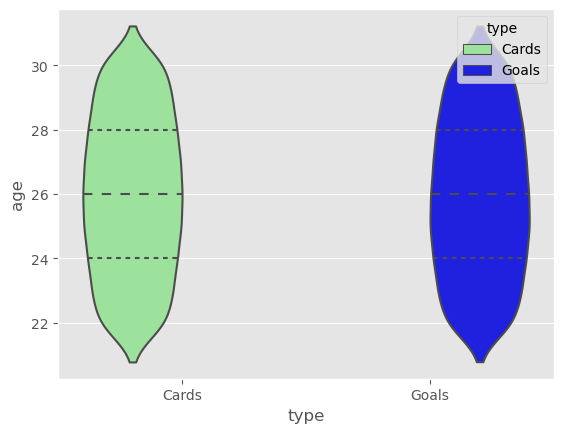

In [28]:
sns.violinplot(x= 'type',y='age',data= data_frames.query('description != "assist"'), bw = 0.25, hue='type',fill=False, palette={"Goals": "b", "Cards": "lightgreen"}, inner="quart" )

<Axes: xlabel='type', ylabel='age'>

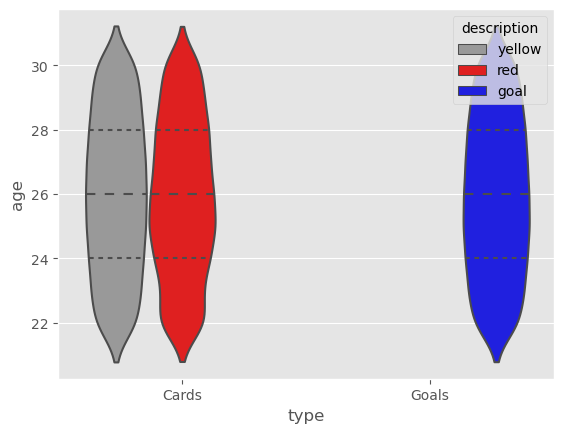

In [29]:
sns.violinplot(x='type', y='age', data=data_frames.query('description != "assist"'), bw=0.25, hue='description', fill=False, palette={"goal": "b", "yellow": '0.6', "red": "r"}, inner="quart")


## joint plot
We chose to visualize the event types (yellow card, red card, goal, assist) to study the density of events watching the relation between the age of players and the date. 
The target is to observe if the 'peak age' is changed trough time.

As you can see, the accumulation of card and assist event are around 2013 and 2023, revealing an erroneous choice of the samples.

In [ ]:
data_frames['age'] = data_frames['age'].astype('string')

C:\ProgramData\miniconda3\envs\geopandas_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\miniconda3\envs\geopandas_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\miniconda3\envs\geopandas_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\miniconda3\envs\geopandas_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

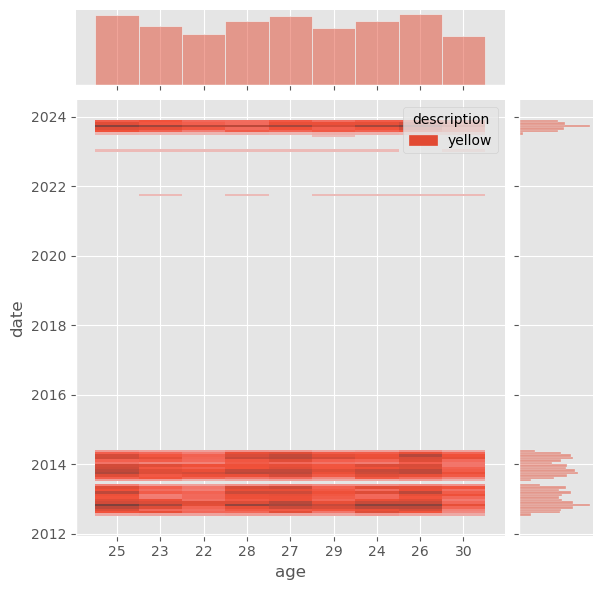

In [31]:
g = sns.jointplot(
    data=data_frames.query("description == 'yellow'"),
    x="age", y="date", hue="description",
    kind="hist",
)

C:\ProgramData\miniconda3\envs\geopandas_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\miniconda3\envs\geopandas_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\miniconda3\envs\geopandas_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\miniconda3\envs\geopandas_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

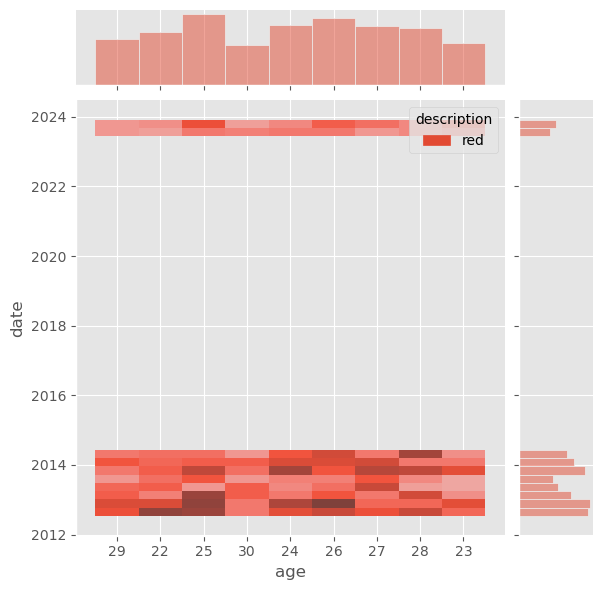

In [32]:
g = sns.jointplot(
    data=data_frames.query("description == 'red'"),
    x="age", y="date", hue="description",
    kind="hist",
)

C:\ProgramData\miniconda3\envs\geopandas_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\miniconda3\envs\geopandas_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\miniconda3\envs\geopandas_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\miniconda3\envs\geopandas_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

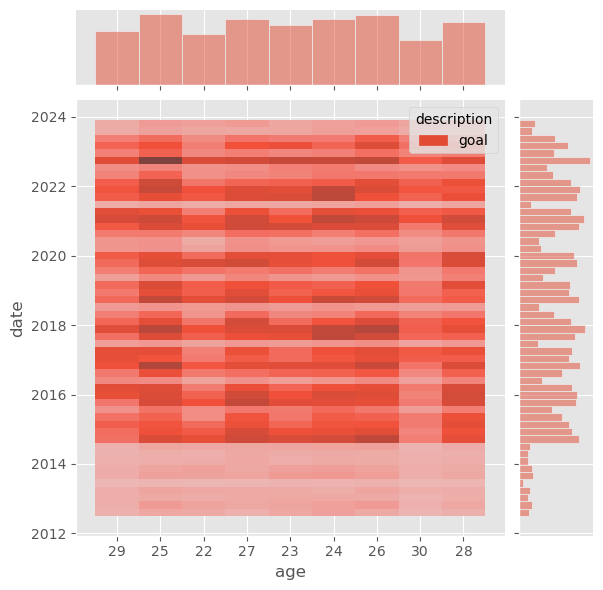

In [33]:
g = sns.jointplot(
    data=data_frames.query("description == 'goal'"),
    x="age", y="date", hue="description",
    kind="hist",
)

In [40]:
ge

,date,type,player_id,description,player_assist_id,player_age,assist_player_age
0,2012-08-05,Cards,4425,yellow,-1,31,-1
1,2012-08-05,Cards,33210,yellow,-1,25,-1
2,2012-08-05,Goals,36500,assist,56416,26,25
3,2012-08-05,Goals,36500,assist,146258,26,18
5,2012-08-05,Goals,38497,assist,33210,25,25
...,...,...,...,...,...,...,...
666528,2023-11-14,Cards,67339,yellow,-1,38,-1
666534,2023-11-14,Cards,201570,yellow,-1,28,-1
666535,2023-11-14,Goals,201570,goal,918868,28,-1
666539,2023-11-15,Cards,129558,yellow,-1,32,-1


In [42]:

assist_df = ge.query('description == "assist"')[['date', 'type','description', 'player_assist_id', 'assist_player_age']].rename(columns={'player_assist_id':'player_id', 'assist_player_age':'player_age'}).loc[ge['player_assist_id']>=0]
goals_df = ge.loc[ge['player_age']>=0].drop(columns=['player_assist_id', 'assist_player_age']).loc[ge['description']!='assist']
ge_light = pd.concat([goals_df, assist_df]).drop(columns=['player_id']).reset_index(drop=True).rename(columns={'player_id':'player_assist_id', 'player_age':'age'})

In [44]:
ge_light

,date,type,description,age
0,2012-08-05,Cards,yellow,31
1,2012-08-05,Cards,yellow,25
2,2012-08-05,Cards,yellow,23
3,2012-08-05,Cards,yellow,23
4,2012-08-05,Cards,yellow,22
...,...,...,...,...
213344,2023-11-22,Goals,assist,35
213345,2023-11-22,Goals,assist,28
213346,2023-11-14,Goals,assist,24
213347,2023-11-14,Goals,assist,28


C:\ProgramData\miniconda3\envs\geopandas_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\miniconda3\envs\geopandas_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\miniconda3\envs\geopandas_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\miniconda3\envs\geopandas_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

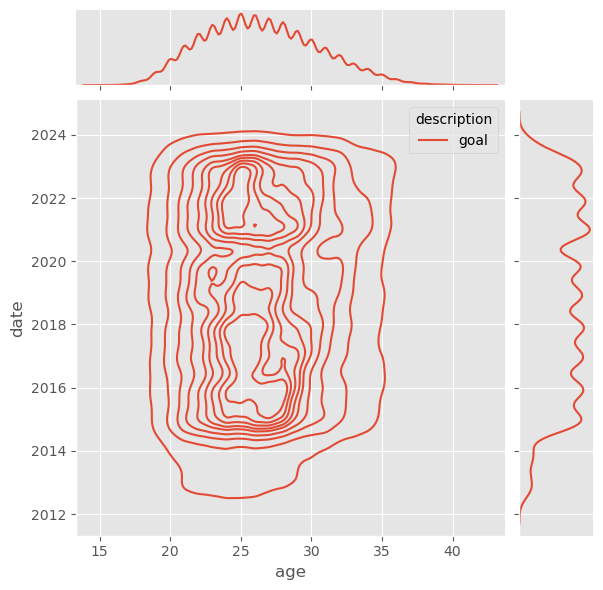

In [47]:
g = sns.jointplot(
    data=ge_light.query("description == 'goal'"),
    x="age", y="date", hue="description",
    kind="kde",
)

C:\ProgramData\miniconda3\envs\geopandas_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\miniconda3\envs\geopandas_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\miniconda3\envs\geopandas_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\miniconda3\envs\geopandas_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

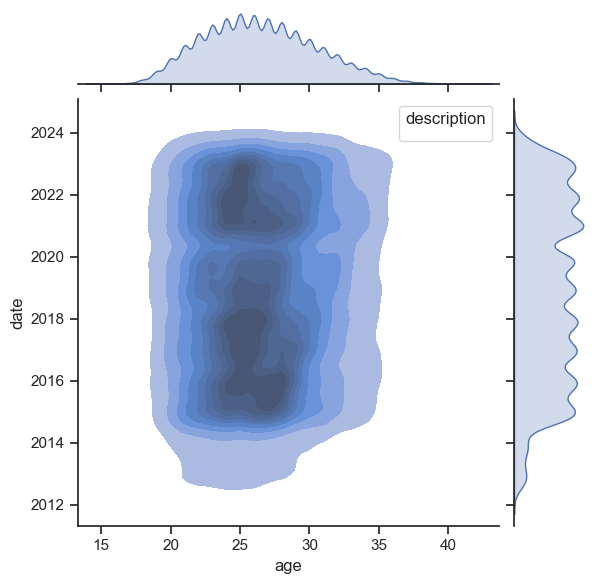

In [51]:
# Set the theme
sns.set_theme(style="ticks")

# Load the penguins dataset
penguins = sns.load_dataset("penguins")

# Create a JointGrid
g = sns.JointGrid(
    data=ge_light.query("description == 'goal'"),
    x="age", y="date", hue="description"
)

# Plot the KDEs with gradient fill on the joint plot
g.plot(sns.kdeplot, sns.kdeplot, fill=True)

# Add a legend
g.ax_joint.legend(title='description')

# Show the plot
plt.show()